In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from scipy.stats import multivariate_normal

In [3]:
N, D = 1000, 10
K = 4
random_data = []
for k in range(K):
    random_locs = np.random.randn(D)*10
    random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
    random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
    random_data.append(multivariate_normal(mean=random_locs,cov=random_covariance).rvs(size=N//K))

In [4]:
random_data = np.array(random_data).reshape(N,-1)

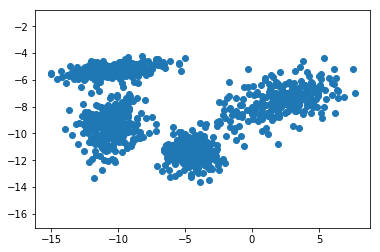

In [5]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [6]:
class CompositionalModel:
    """Base class for compositional models"""
    def __init__(self, X, parent = None):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        if not parent is None:
            assert issubclass(type(parent), CompositionalModel), "%r is not a CompositionalModel" % parent
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        self.parent = parent
        self.lock = True
        
    def __repr__(self):
        return ''
    
    def model(self, X):
        return X
    
    def conditionModel(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        return None
    
    @pyro.ops.jit.trace
    def model_log_prob_fn(self):
        tr = pyro.poutine.trace(self.conditioned_model).get_trace(self.X)
        return tr.log_prob_sum()
        
    def per_param_callable(self, module_name, param_name):
        return {"lr": 0.01, 'betas': [0.9, 0.99]}

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss
        
    def inference(self, n_iter = 500):
        self.conditionModel(self.X)
        optim = pyro.optim.Adam(self.per_param_callable)
        elbo = Trace_ELBO()
        self.svi = SVI(self.conditioned_model, self.guide, optim, loss=elbo)

        #loss, seed = min((initialize(seed), seed) for seed in range(100))
        if self.lock:
            self.initialize(np.random.randint(1000))
            # Register hooks to monitor gradient norms.
            self.losses = []
            self.gradient_norms = defaultdict(list)
        
        # register gradient hooks for monitoring
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: self.gradient_norms[name].append(g.norm().item()))

        # optimize
        for i in range(n_iter):
            loss = self.svi.step(self.X)
            self.losses.append(loss)
            print('.' if i % 100 else '\n', end='')
        
        # after initializing model in parent-model, finetune it
        if self.lock:
            self.lock = False
            print("\n")
            print("Finetuning")
            self.inference(n_iter = 1000)
        self.params = pyro.get_param_store()
    
    def plot_learning_curve(self):
        pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        pyplot.plot(self.losses)
        pyplot.xlabel('iters')
        pyplot.ylabel('loss')
        pyplot.yscale('log')
        pyplot.title('Convergence of SVI');
        
    def plot_gradient_norms(self):
        pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
        for name, grad_norms in self.gradient_norms.items():
            pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
        
    def predictive_check(self):
        guide_trace = pyro.poutine.trace(self.guide).get_trace(self.X)
        posterior_predictive = pyro.poutine.replay(self.model, guide_trace)
        return posterior_predictive(self.X).detach().numpy()

In [7]:
class LowRankGaussian(CompositionalModel):
    """Gaussian obervations with low rank covariance matrix"""
    def __init__(self, X, parent = None):
        super(LowRankGaussian, self).__init__(X, parent)
        
    def __repr__(self):
        return 'GG + G'
    
    def model(self, X):
        cov_factor = torch.zeros((D,D))
        with pyro.plate('D', self.D) as d:
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            cov_diag = pyro.sample('cov_diag', dst.LogNormal(0.,4.))
            cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(torch.zeros(D),10.).to_event(1))
            cov_factor[:,d] = cov_factor_column
        with pyro.plate('N', self.N):
            X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
        return X
    
    def guide(self, X):
        # mean field
        K = self.D
        cov_factor = torch.zeros((D,D))
        with pyro.plate('D', self.D) as d:
            # define parameters
            loc_mean = pyro.param('loc_mean', torch.zeros(D, requires_grad = False))
            loc_scale = pyro.param('loc_scale', torch.ones(D), constraint=constraints.positive)
            cov_factor_mean = pyro.param('cov_factor_mean', torch.zeros(D,K))
            cov_factor_scale = pyro.param('cov_factor_scale', torch.ones(D,K), constraint=constraints.positive)
            cov_diag_mean = pyro.param('cov_diag_mean', torch.zeros(D))
            cov_diag_scale = pyro.param('cov_diag_scale', torch.ones(D), constraint=constraints.positive)
            # sample variables
            loc = pyro.sample('loc', dst.Normal(loc_mean,loc_scale))
            cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(cov_factor_mean, cov_factor_scale).to_event(1))
            cov_factor[:,d] = cov_factor_column
            cov_diag = pyro.sample('cov_diag', dst.LogNormal(cov_diag_mean, cov_diag_scale))
        return loc, cov_factor, cov_diag
    
    def per_param_callable(self, module_name, param_name):
        #if param_name in ['loc_mean']:
        if self.lock and param_name in ['loc_mean', 'cov_diag_mean']:
            return {"lr": 0.0, 'betas': [0.9, 0.99]}
        else:
            return {"lr": 0.01, 'betas': [0.9, 0.99]}

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        pyro.param('loc_mean', self.parent.params['loc_delta'])
        pyro.param('cov_diag_mean', self.parent.params['scale_delta'], constraint=constraints.positive)
        #pyro.clear_param_store()
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss

In [8]:
class IndependentGaussian(CompositionalModel):
    """Gaussian observations with no latent structure"""
    def __init__(self, X, parent = None):
        super(IndependentGaussian, self).__init__(X, parent = None)
        
    def __repr__(self):
        return 'G'
    
    def model(self, X):
        with pyro.plate('D', self.D):
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            scale = pyro.sample('scale', dst.LogNormal(0.,4.))
            with pyro.plate('N', self.N):
                X = pyro.sample('obs', dst.Normal(loc,scale))
        return X
    
    def guide(self, X):
        # MAP
        with pyro.plate('D', self.D):
            loc_delta = pyro.param('loc_delta', torch.zeros(self.D))
            scale_delta = pyro.param('scale_delta', torch.ones(self.D), constraint=constraints.positive)
            loc = pyro.sample('loc', dst.Delta(loc_delta))
            scale = pyro.sample('scale', dst.Delta(scale_delta))
        return loc, scale
    
    def per_param_callable(self, module_name, param_name):
        #if param_name in ['loc_mean']:
        if self.lock and param_name in ['loc_mean', 'cov_diag_mean']:
            return {"lr": 0.0, 'betas': [0.9, 0.99]}
        else:
            return {"lr": 0.01, 'betas': [0.9, 0.99]}

    def initialize(self, seed):
        # evaluate loss on a randomly initialized parameter-set 
        pyro.set_rng_seed(seed)
        pyro.clear_param_store()
        pyro.param('loc_delta', self.X.mean(0))
        pyro.param('scale_delta', self.X.std(0), constraint=constraints.positive)
        loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
        return loss

In [9]:
ig = IndependentGaussian(random_data)

In [10]:
ig.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

Finetuning

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
......................................................................................

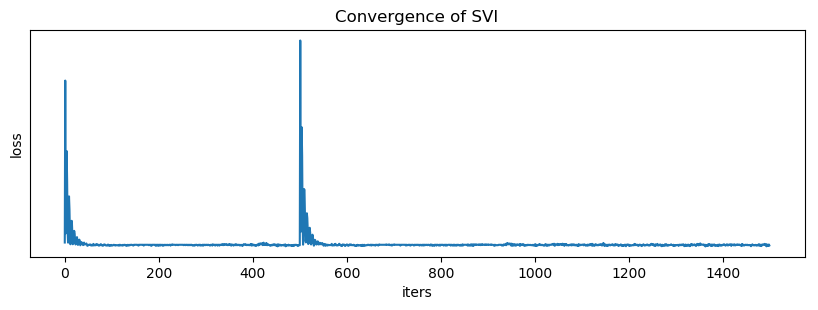

In [11]:
ig.plot_learning_curve()

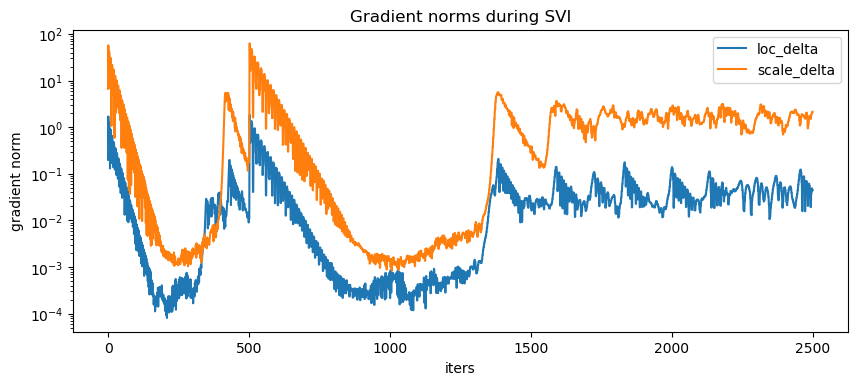

In [12]:
ig.plot_gradient_norms()

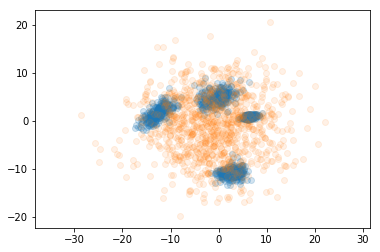

In [13]:
# plot two random dimensions against each other
random_idx = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idx].T, alpha=.2)
pyplot.scatter(*ig.predictive_check()[:,random_idx].T, alpha=.1)
pyplot.axis('equal');

In [14]:
fa = LowRankGaussian(random_data, parent=ig)

In [15]:
fa.parent

G

In [16]:
fa.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

Finetuning

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
......................................................................................

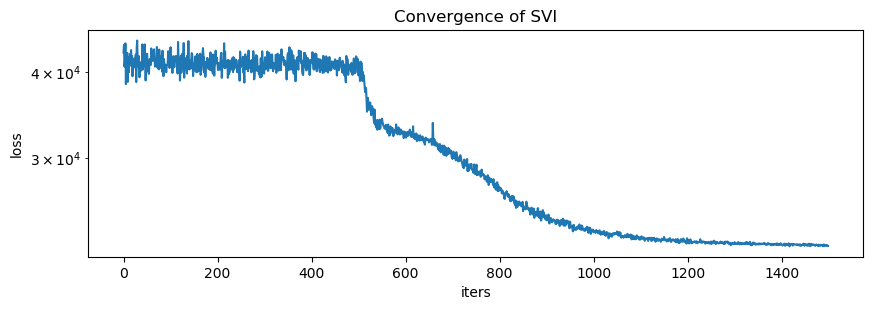

In [39]:
fa.plot_learning_curve()

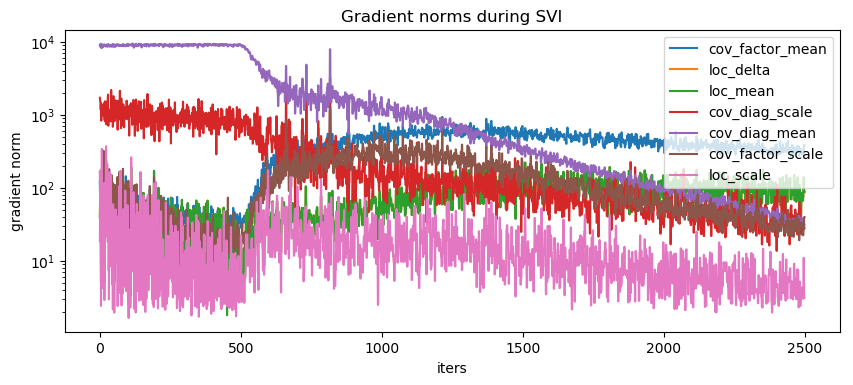

In [37]:
fa.plot_gradient_norms()

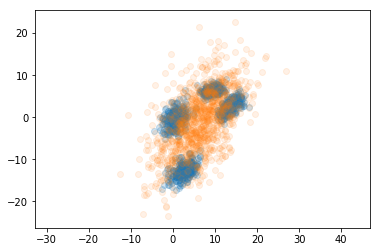

In [36]:
# plot two random dimensions against each other
random_idx = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idx].T, alpha=.2)
pyplot.scatter(*fa.predictive_check()[:,random_idx].T, alpha=.1)
pyplot.axis('equal');

In [23]:
random_idx

array([2, 4])

In [19]:
fa.predictive_check()

array([[ -2.8435369 ,   0.8800591 ,  -3.0423958 , ...,  -3.0092163 ,
        -10.774019  ,  -2.7851381 ],
       [ -0.2946661 ,   7.3240743 , -19.035568  , ..., -18.607107  ,
         -5.408685  , -11.077737  ],
       [-20.961912  ,  -1.0332975 ,  -6.916068  , ...,   3.3375573 ,
         -3.9645476 ,   6.3319755 ],
       ...,
       [ 12.431471  ,   5.493232  ,  -3.4584284 , ..., -11.160001  ,
        -10.582543  ,  -9.396739  ],
       [-13.52478   ,   6.181503  ,  -5.4923477 , ...,  -2.249976  ,
         -3.8884685 ,  -0.5548686 ],
       [ -7.5795236 ,   0.2503277 ,  -2.4549785 , ...,   0.624467  ,
         -9.474515  ,  -0.57808167]], dtype=float32)